# Q-Matrix Mining
(Based on Barnes 2010, Brewer 1996)
This model is used to explain the power law in learning.  In this notebook we try to build a neuralised version of the AFM and train it using simulated data.  The aim of using the AFM is to disentangle the latent traits that make up the overall score going into the sigmoid probability estimator.

The model is compensatory, which is a weakness.

In [409]:
import sys
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.INFO)
from collections import defaultdict, Counter
from copy import copy
from math import exp, sqrt, log
from random import random, shuffle, choice, randint, uniform
import numpy

from keras import Input, Model
from keras.callbacks import EarlyStopping
from keras.constraints import non_neg, max_norm
from numpy import array, mean, ones
from pandas import concat
from pandas import DataFrame
from keras.models import Sequential
from keras.layers import LSTM, multiply, subtract, add, Activation, Lambda, Flatten
from keras.layers import Dense, concatenate, MaxPooling1D, LocallyConnected1D, Reshape
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras import constraints

from utils import generate_student_name
import random

from matplotlib import pyplot as plt

n_traits = 5

import logging
# Create logger
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

# Create STDERR handler
handler = logging.StreamHandler(sys.stderr)
# ch.setLevel(logging.DEBUG)

# Create formatter and add it to the handler
formatter = logging.Formatter('%(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)

# Set STDERR handler as the only handler 
logger.handlers = [handler]


In [410]:
generate_student_name()

'MUHUG JININ '

In [411]:
from keras import backend as K
from keras.constraints import Constraint
from keras.engine.topology import Layer
from keras import initializers

class WeightClip(Constraint):
    '''Clips the weights incident to each hidden unit to be inside a range
    '''
    def __init__(self, min_w=0, max_w=4):
        self.min_w = min_w
        self.max_w = max_w

    def __call__(self, p):
        return K.clip(p, self.min_w, self.max_w)

    def get_config(self):
        return {'name': self.__class__.__name__,
                'min_w': self.min_w,
                'max_w': self.max_w }

In [412]:
class BigTable(Layer):

    def __init__(self, _dim, min_w, max_w, **kwargs):
        self.dim = _dim
        self.limits = (min_w, max_w)
        kc =kernel_constraint=WeightClip(min_w, max_w)
        self.kernel_constraint= constraints.get(kc)
        super(BigTable, self).__init__(**kwargs)
        
    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        min_w, max_w = self.limits
#         av_w = (min_w + max_w)/2.0
        initialiser = initializers.RandomUniform(min_w, max_w)  #.RandomUniform(min_w, max_w)
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(self.dim),
                                      initializer=initialiser,
                                      trainable=True,
                                      constraint=self.kernel_constraint)
        print("kk", self.kernel.shape)
        super(BigTable, self).build(input_shape)  # Be sure to call this at the end

    def call(self, selector):
        print("selector shape", selector.shape)
        selector = K.flatten(selector)
        print("flat selector shape", selector.shape)
        print("call kk", self.kernel.shape)
#         selector = tf.Print(selector, [selector], message="selector is:", first_n=-1, summarize=1024)
        rows = K.gather(self.kernel, selector)
#         rows = tf.Print(rows, [rows], message="row is:", first_n=-1, summarize=1024)
        print("'rows' shape,",rows.shape)
        return rows

    def compute_output_shape(self, input_shape):
        return ((None, self.dim[1]))


In [432]:
class Question():
    def __init__(self, qix, min_diff, max_diff, nt, min_active, max_active):
        self.id = qix
        print("Qinit",qix)

        n_c = randint(min_active, max_active)
        choices = numpy.random.choice(range(nt), size=n_c, replace=False)

        print("Q choices are {}".format(choices))

        not_present= 0 #min_diff
        self.betas = [ not_present for _ in range(nt) ]        

        for c in choices:
#             self.betas[c] = min_diff
#             self.betas[c] = random.uniform(min_diff, max_diff)
            self.betas[c]= 1.0 #randint(0,1)
    def get_magnitude(self):
        comps = [c for c in self.betas if c>0]
        mag = sqrt(sum([ pow(b, 2) for b in comps ]))
        return mag
    def get_num_components(self):
        return len([c for c in self.betas if c>0])

    
class Student():
    def __init__(self, ix, min_a, max_a, nt):
        self.id = ix
        self.name = generate_student_name()
        n_c = randint(0,nt)
        choices = numpy.random.choice(range(nt), size=n_c, replace=False)

        not_present= 0 #min_a
        self.thetas = [ not_present for _ in range(nt) ]        

        for c in choices:
            self.thetas[c] = 1 #randint(0,1)
    def get_magnitude(self):
        comps = [c for c in self.thetas if c>0]
        mag = sqrt(sum([ pow(b, 2) for b in comps ]))
        return mag
    def get_num_components(self):
        return len([c for c in self.thetas if c>0])
        


In [414]:
for z in [-20, -10, -4,-3,-2,-1,0,1,2,3,4]:
    print( 1/(1+exp(-z)) )
    
    
n_traits = 5
q_p_min = 0.01
q_p_max = .99

pr_k_easiest = q_p_max**(1/n_traits)
pr_k_hardest = q_p_min**(1/n_traits)

print(pr_k_hardest, pr_k_easiest)

inv_sigmoid = lambda pr : ( -log((1/pr) -1) )
k_delta_easiest = inv_sigmoid(pr_k_easiest)
k_delta_hardest = inv_sigmoid(pr_k_hardest)

print(k_delta_easiest, k_delta_hardest)
import math

k_delta_easiest = math.ceil(k_delta_easiest)
k_delta_hardest = math.floor(k_delta_hardest)
print(k_delta_easiest, k_delta_hardest)

beta_min = 0
theta_max = beta_min + k_delta_easiest
beta_max = theta_max
theta_min = beta_max - abs(k_delta_hardest)

print("th", theta_min, theta_max)
print("b", beta_min, beta_max)


2.0611536181902037e-09
4.5397868702434395e-05
0.01798620996209156
0.04742587317756678
0.11920292202211755
0.2689414213699951
0.5
0.7310585786300049
0.8807970779778823
0.9525741268224334
0.9820137900379085
0.39810717055349726 0.9979919516614258
6.208581937276601 -0.41335816350087323
7 -1
th 6 7
b 0 7


In [415]:
def attempt_q(student: Student, q: Question):
    p = calculate_pass_probability(student.thetas, q.betas)
#     this_att = uniform(0,1)
#     if (this_att <= p):
#         passed=True
# #         student.mastery[q.id] = 1
#     else:
#         passed=False

    passed = p

    return passed

In [416]:
def calculate_pass_probability(thetas, betas):
    # additive factors model is:
    # p_pass = 1 / 1 + exp(-z)
    # where z = a + sum[1:n]( -b + gT )
    
    p_pass = 1.0
#     print("th,b",thetas,betas)
    
    for th,b in zip(thetas,betas):
        if b > th:
            p_pass = 0
        
    #print("real p_pass = {}".format(p_pass))
    return p_pass
    

In [417]:
#qs= create_qs(n_qs, minb,maxb, n_traits, min_active_traits, max_active_traits, nnw)
def create_qs(n_qs, beta_min, beta_max, nt, min_active, max_active):
#     random.seed(666)
#     numpy.random.seed(666)
    master_qs = [Question(qix, beta_min,beta_max, nt, min_active, max_active) for qix in range(n_qs)]
    mags = []
    no_comps = []
    for q in master_qs:
        mag = q.get_magnitude()
        nc = q.get_num_components()
        print("Q:{}, difficulty={:.2f} across {} components".format(q.id, mag, nc))
        mags.append(mag)
        no_comps.append(nc)
    
    plt.hist(mags)
    plt.show()
    plt.hist(no_comps)
    plt.show()
    
    for q in master_qs:
        print("qid",q.id,q.betas)
  
    return master_qs

# Training
This is where sh!t gets real.  We take our tr_len (1000?) students, and iterate over them 100 times to create 100,000 *complete examples* of a student attacking the curriculum.  The questions themselves are attacked in random order: the student has no intelligent guidance throught the material. (Obvious we may wish to provide that guidance at some point in the future.)

Remember, there are only 12 exercises in the curriculum, so if the student is taking 60 or 70 goes to answer them all, that's pretty poor.  But some of these kids are dumb as lumber, so cut them some slack!  They will all get there in the end since by the CMU AFM practice will, eventually, make perfect!

In [418]:
def create_students(n_students, theta_min, theta_max, nt):
#     random.seed(666)
#     numpy.random.seed(666)
    psi_list = [ Student(psix, theta_min,theta_max, nt=nt) for psix in range(n_students)]
    mags = []
    for psi in psi_list[0:30]:
        mag = psi.get_magnitude()
        nc = psi.get_num_components()
        print("{}, skill={:.2f} across {} comps".format(psi.name, mag, nc))
        mags.append(mag)
    
 ################ PLOTs follow

    fig,ax = plt.subplots(1,2)
    fig.set_size_inches(20,10)
    
    ax[0].hist(mags)

    if nt >1:
        itemz = array([ s.thetas for s in psi_list ])
    #     fig.set_size_inches(10, 10)
        ax[1].scatter(itemz[:,0], itemz[:,1], alpha=0.2)
        for i, txt in enumerate(itemz):
            ax[1].annotate(i, (itemz[i,0], itemz[i,1]))
        plt.show()
    
    return psi_list
    

In [419]:
extend_pop=False
extend_by = 90
if extend_pop:
    for _ in range(extend_by):
        nu_psi = Student(nt=n_traits, nq=len(master_qs), optimiser=psi_opt)
        psi_list.append(nu_psi)

In [428]:
def generate_qs_model(qn_table, psi_table, qn_qmx, psi_qmx, optimiser):
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
    print(qn_table, psi_table, psi_sel, qn_sel)
    print("psi_sel shape", psi_sel.shape)

    psi_table.trainable=True
    qn_table.trainable=True
    
    qn_row = qn_table(qn_sel)    
    psi_row = psi_table(psi_sel)

#     qn_qmx_row = qn_qmx(qn_sel)

#     q_masque = Lambda(lambda q: K.clip(q,0,1))(qn_row)
#     s_masque = Lambda(lambda s: K.clip(s,0,1))(psi_row)

    q_masque = qn_row
    s_masque = psi_row

#     q1_s1 = Lambda(lambda qs: qs[0] * qs[1])([q_masque, s_masque])
#     q0 = Lambda(lambda q: 1-q)(q_masque)

#     qn_row= Dropout(0.0)(qn_row)
#     psi_row = Dropout(0.0)(qn_row)
    
#     dif = subtract([psi_row, qn_row])
#     print("dif",dif.shape)
#     Prs = Lambda(lambda z: 1.0 / (1.0 + K.exp(-z)), name="sPr_sigmoid")(dif)
#     Prs = multiply([Prs, q1_s1])
#     Prs = add([Prs, q0])

    Prs = Lambda(lambda ps_q:  (ps_q[0]*ps_q[1]) + (1.0-ps_q[0]) ) ([q_masque, s_masque])
#     Prs = Lambda(lambda u: K.clip(u,0,1))(Prs)
#     Prs = multiply([Prs, qmx_selector])

#     Pr = Lambda(lambda ps: K.exp(K.sum(K.log(ps), axis=1, keepdims=True)), name="sPr_prod")(Prs)
    Pr = Lambda(lambda ps: K.min(ps, axis=1, keepdims=True), name="sPr_prod")(Prs)

    print("Pr",Pr.shape)
    model = Model(inputs=[qn_sel, psi_sel], outputs=Pr)
    model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["mse","accuracy"])
    return model

In [421]:
import gc
def generate_attempts(master_qs, psi_list):
    attempts =[]
    attempts_by_q = {}
    attempts_by_psi = {}
    attempt_n_map = Counter()

    user_budget = math.inf
    user_patience = 10 #math.inf
    pass_to_remove = True
    
    n_pass = 0
    for run in range(1):
        print("----{}\n".format(run))
        for psi in psi_list:
            spend=0
            qs = [ix for ix in range(len(master_qs))]
            while qs:
                qix = random.choice(qs)
                q = master_qs[qix]
                passed=0

                if psi.name not in attempts_by_psi:
                    attempts_by_psi[psi.name]=[]

                if q not in attempts_by_q:
                    attempts_by_q[q]=[]

                att = 0
#                 while (not passed) and att<user_patience:
                passed = attempt_q(psi, q)
                if passed:
                    n_pass+=1
                tup = (psi.id, q.id, passed, passed)
                attempt_n_map[(q.id,psi.id)] += 1
                attempts.append(tup)
#                 print("p_pass was",pp,"=",passed) #, "run p:", 1-(1-pp)**max_atts)
                attempts_by_psi[psi.name].append(tup)
                attempts_by_q[q].append(tup)
                att += 1
#                 if (not pass_to_remove) or (pass_to_remove and passed):
                qs.remove(qix)
#                 print("len qs is", len(qs))
    gc.collect()
    print(">>Passed {}/{}".format(n_pass, len(attempts)))
    return attempts, attempts_by_q, attempts_by_psi, attempt_n_map

In [422]:
def calc_avg_MAE(qs,ss,sws,qws):
    s_wgtz = array([ s.thetas for s in ss ])
    shat_wgtz = sws
    shat, smin_total_err, mean_ll, cos_dis = calc_arr_arr_err(s_wgtz, shat_wgtz, max_iter=10)

    real_wgtz = array([ q.betas for q in qs ])
    pred_wgtz = qws
    chosen, qmin_total_err, mean_ll, cos_dis = calc_arr_arr_err(real_wgtz, pred_wgtz, max_iter=10)

    return (smin_total_err, qmin_total_err)

In [423]:
def calc_arr_arr_err(real_wgts, pred_wgts, max_iter=10):
    from scipy.spatial.distance import cosine
# pred_wgts = numpy.round(pred_wgts,1)

    out_cols = [None] * len(real_wgts.T)
    curr_sel = None
    curr_ix = None
    n_iters = 10
    chosen = None

    indices = range(len(real_wgts.T))

    min_total_err = math.inf
    best_cos_dis = math.inf
    for i in range(max_iter): #len(indices)**2):
        real_used = set()
        pred_used = set()
        while len(pred_used) < len(indices):
            curr_err = math.inf
            curr_cos = math.inf
            for rix in numpy.random.permutation(indices):
                if rix in real_used:
                    continue
                real_col = real_wgts.T[rix]
                for cix in numpy.random.permutation(indices):
                    if cix in pred_used:
                        continue
                    pred_col = pred_wgts.T[cix]
                    err = numpy.mean(numpy.abs( pred_col - real_col))
                    #print("mae is ",mse)
                    if err < curr_err:
    #                     print("best match", cix, rix)
    #                     print(real_col)
    #                     print(pred_col)
                        curr_sel = pred_col
                        curr_err = err
                        curr_cos = cosine(pred_col, real_col)
                        curr_ix = cix
                        curr_real_ix = rix
    #         print("---")
            real_used.add(curr_real_ix)
            pred_used.add(curr_ix)
            out_cols[curr_real_ix] = curr_sel
        out_col_arr = array(out_cols).T
        total_err = numpy.mean(numpy.abs( out_col_arr - real_wgts ))
        cos_dis = cosine(out_col_arr.flatten(), real_wgts.flatten())
        mean_ll = numpy.mean( out_col_arr - real_wgts )
#         if total_err < min_total_err:
        if cos_dis < best_cos_dis:
            min_total_err = total_err
            best_ll = mean_ll
            chosen = out_col_arr
            best_cos_dis = cos_dis
#             print("new total min mae:", min_total_err)
#             print("new best ll", best_ll)
    return chosen, min_total_err, mean_ll, best_cos_dis

In [424]:
import pandas
def results_sheet(qs,ss,thetas, betas):
    base = 2
    summa = 0
    tp,fp,tn,fn=0,0,0,0
    x = []
    summa = 0
    rows = []
    for _ in range(1):
        xa, _, _, _ = generate_attempts(qs,ss)
        x.extend(xa)
        
    N = len(x)
    
    ix=0    
    for tup in x:
        (psi_id, q_id, passed, passed) = tup
        p = calculate_pass_probability(ss[psi_id].thetas, qs[q_id].betas)

        summa += log((p if passed else (1-p)), base)
        
        pp = uniform(0,1)
        if pp <= p:
            ppassed=1
            if passed:
                tp+=1
            else:
                fp+=1
        else:
            ppassed=0
            if passed:
                fn+=1
            else:
                tn+=1

        row = [psi_id, q_id, passed, ppassed, None, p, None, None, None, None]
        rows.append(row)
    #     print(ix)
        ix += 1

    ix=0
    for tup in x:
        (psi_id, q_id, passed, p) = tup
        phat = calculate_pass_probability(thetas[psi_id], betas[q_id])
#         row = [psi_id, q_id, passed, None, None, p, phat, None, None, None]
#         LR_rows.append([psi_id, q_id] + list(thetas[psi_id]) + list(betas[q_id]) + [phat, passed] )

#         print(phat, passed)
#         summa += log((phat if passed else (1-phat)), base)

        pp = uniform(0,1)
        if pp <= phat:
            ppassed= 1
            if passed:
                tp+=1
            else:
                fp+=1
        else:
            ppassed = 0
            if passed:
                fn+=1
            else:
                tn+=1
    #     df.iloc[ix,4]=ppassed
    #     df.iloc[ix,6]=p
        rows[ix][4] = ppassed
        rows[ix][6] = phat
        p = rows[ix][5]
        residual =  ppassed-p
    #     print("residual is {}-{}:{}".format(ppassed,p,residual))
        std_residual = residual**2 #/ (p*(1-p))
    #     print("res^2/V=",std_residual)
        rows[ix][7]=residual
        rows[ix][8]=(p*(1-p))
        rows[ix][9]=std_residual
        ix+=1
    rows.append(row)
    

    idx=["s_id","q_id","run0","rerun","mined","p0","p_mined", "residual", "W", "std.resid^2"]
    df = pandas.DataFrame(data=rows, columns=idx)

    MSR = numpy.mean(df["std.resid^2"])
    print("Outfit=",MSR)

    ct=0
    in_tol_ct=0
    out_in_tol_ct=0
    over1_2=0
    out_over1_2=0
    exxx=0
    inxxx=0
    infits = []
    outfits = []
    for q_id in [q.id for q in qs]:
        q_df = df[df["q_id"]==q_id]
        infit = numpy.sum(q_df["std.resid^2"]*q_df["W"])/numpy.sum(q_df["W"])
        outfit = numpy.mean(q_df["std.resid^2"])
        infits.append(infit)
        outfits.append(outfit)
        print("Infit=",infit,"for",q_id)
        print("Outfit=",outfit)
        if infit<1.1:
            in_tol_ct+=1
        elif infit >1.2 and infit < 1.3:
            over1_2+=1
        elif infit >= 1.3:
            inxxx +=1

        if outfit<1.1:
            out_in_tol_ct+=1
        elif outfit >1.2 and outfit < 1.3:
            out_over1_2+=1
        elif outfit >= 1.3:
            exxx +=1
        ct+=1

    infits = array(infits)
    low = numpy.sum(infits<1.1)
    med = numpy.sum((infits>=1.1) & (infits<1.2))
    hi  = numpy.sum((infits>=1.2) & (infits<1.5))
    out = numpy.sum(infits>=1.5)
    print("infit {} ({} {} {} {})".format(numpy.mean(infits),low,med,hi,out))
    # print("infits in tolerance:", in_tol_ct, "/", (ct-in_tol_ct-over1_2), "({},{})".format(over1_2, inxxx))
    outfits = array(outfits)
    print("avg outfit = ", numpy.mean(outfits))
    # print("Outfits in tolerance:", out_in_tol_ct, "/", (ct-out_in_tol_ct-out_over1_2), "({},{})".format(out_over1_2, exxx))
    low = numpy.sum(outfits<1.1)
    med = numpy.sum((outfits>=1.1) & (outfits<1.2))
    hi  = numpy.sum((outfits>=1.2) & (outfits<1.5))
    out = numpy.sum(outfits>=1.5)
    print("outfit {} ({} {} {} {})".format(numpy.mean(outfits), low,med,hi,out))    

    origMSE = numpy.mean((df["run0"] - df["p0"])**2)
    print("origMSE",origMSE)
    embedMSE = numpy.mean((df["run0"] - df["p_mined"])**2)
    print("embedMSE",embedMSE)

    df.to_csv("mltm.{}_{}_{}.df.csv".format(n_traits, min_active_traits, max_active_traits))
    acc = (tp+tn)/len(x)
    print("embed acc:",acc)
    print(tp,fp)
    print(fn,tn)

#     ppx = pow( base, (-summa/N))
#     print("perplexity is {}".format(ppx))
#     print((fn + fp + abs(tp-tn)),":", tp,tn,fp,fn)
    return df

In [425]:
import os
import IPython

def calibrate(master_qs, psi_list, qs_model, attempts, val, attempts_by_psi, attempts_by_q, s_table, q_table, s_qmx_table, q_qmx_table, n_iter=20, record_param_fit=False):
    es = EarlyStopping(monitor="val_loss", mode="auto", patience=0)
#     random.seed(666)
    min_mse = 1000
    min_avg_fit_rmse = math.inf
    min_loss= math.inf
    q_outer_mses = []
    q_outer_accs = []
    s_outer_mses = []
    s_outer_accs = []
    th_mses = []
    b_mses = []
    th_accs= []
    b_accs =[]
    h= []
    avg_fit_rmses = []
    th_fit_rmses = []
    b_fit_rmses = []
    init_patience = 100
    patience = init_patience

    shuffle(attempts)

    qices = array([int(tup[1]) for tup in attempts]).flatten() #reshape(-1,1)
    psices = array([int(tup[0]) for tup in attempts]).flatten() #reshape(-1,1)
    pfs = array([tup[3] for tup in attempts]).flatten() #reshape(-1,1)
    len_all = qices.shape[0]
    
    split = len_all//10
    
#     vqices = qices[0:split] #array([int(tup[1]) for tup in val]).flatten() #reshape(-1,1)
#     vpsices = psices[0:split] #array([int(tup[0]) for tup in val]).flatten() #reshape(-1,1)
#     #vpfs = pfs[0:split] #array([tup[2] for tup in val]).flatten() #reshape(-1,1)
#     vpfs = array([tup[3] for tup in attempts]).flatten()[0:split] #array([tup[2] for tup in val]).flatten() #reshape(-1,1)

    vqices = qices
    vpsices = psices
    vpfs = pfs

#     qz = qices[split:]
#     sz = psices[split:]
#     pfz = pfs[split:]
    qz = qices
    sz = psices
    pfz = pfs
    
    print(qz)
    print(sz)
    print(pfz)
#     input("Xsan")
    
    loss = False
    mse = False
    acc = False
    early_stop = True
    min_stop = 0
#     n_iter = 1

    real_thetas = numpy.sort(array([s.thetas for s in psi_list]))
    real_betas = numpy.sort(array([q.betas for q in master_qs]))

#     n_iter=1
    for i in range(n_iter):
        base_ix = 0
        done = False
#         for j in range(chunkz+1):
        j = 0
        sub_h = []
        
#         predz = qs_model.predict(x=[qz, sz], verbose=0)
#         print("~~~~ ~ ~ ~~~")
#         for ix,(pred,q,s,p) in enumerate(zip(predz,qz,sz,pfz)):
#             print(q,s,p,"-?",pred)
#             if ix>10:
#                 break
        
        qs_model.train_on_batch(x=[qz, sz], y=pfz)#, epochs=10, shuffle=True, batch_size=1, callbacks=[es])
#         qs_model.fit(x=[qz,sz],y=pfz, epochs=1000, validation_split=0.10, batch_size=32, callbacks=[es])
#         qs_model.fit(x=[qz,sz],y=pfz, epochs=1, batch_size=len(pfz), shuffle=True)
      
        if i % 10 == 0:
            loss, mse, acc = qs_model.evaluate(x=[vqices, vpsices], y=vpfs, verbose=0) #, epochs=1, shuffle=True, batch_size=1, verbose=0) #, callbacks=[es])
            sub_h.append((loss,mse,acc))

            print("i =",i)
            
#             av_rmse = (th_rmse/len(psi_list) +b_rmse/len(master_qs))
#             av_rmse = acc #(th_rmse+b_rmse)/2.0
#             av_rmse = b_rmse
            pred_thetas = numpy.sort(s_table.get_weights()[0])
#             if i>0 and i%100 ==0:
#                 noize = numpy.random.uniform(0.99,1.01, size=pred_thetas.shape)
#                 s_table.set_weights([ pred_thetas*noize, ])
                        
            diffz = numpy.abs(pred_thetas - real_thetas)
            differr = numpy.sum(diffz)/len(psi_list*real_thetas.shape[1])
            th_err = differr
            print("th",differr)

            pred_betas = numpy.sort(q_table.get_weights()[0])

#             if i>0 and i%100 ==0:
#                 noize = numpy.random.uniform(0.99,1.01, size=pred_betas.shape)
#                 q_table.set_weights([ pred_betas*noize, ])

            diffz = numpy.abs(pred_betas - real_betas)
            differr = numpy.sum(diffz)/len(master_qs*real_betas.shape[1])
            print("b",differr)

            real_deltas = numpy.repeat(real_thetas, len(real_betas), axis=0) - numpy.repeat(real_betas, len(real_thetas), axis=0)
            pred_deltas = numpy.repeat(pred_thetas, len(pred_betas), axis=0) - numpy.repeat(pred_betas, len(pred_thetas), axis=0)
            delta_deltas = numpy.abs(pred_deltas - real_deltas)
            print(numpy.sum(delta_deltas)/delta_deltas.shape[0])
            
#             print(pred_thetas[0:10])
#             print(real_thetas[0:10])

            av_rmse = (th_err + differr)/2 #numpy.sum(delta_deltas)/delta_deltas.shape[0] #(differr + th_err)/2
            print(av_rmse,mse,acc)
            
            sub_h = numpy.array(sub_h)
#             sub_tup = (sub_h[-1,0],sub_h[-1,1],sub_h[-1,2])
            h.append((th_err, differr, loss,mse,acc))

            print("loss =",av_rmse)
#             if loss< 1e-6:
#                 break
            if av_rmse < min_avg_fit_rmse:
                patience = init_patience
                print("patience reset to", init_patience)
                min_avg_fit_rmse = av_rmse
                min_loss = loss
#                 qs_model.save_weights("qs_best_weights_summative.hdf5")
            else:
                if early_stop and i>min_stop:
#                 if loss < min_loss:
#                     print(loss,"<",min_loss)
                    if patience >0:
                        patience -= 1
                        print("patience now", patience)
                    else:
                        print("Earlying stoppin' @",i)
                        break
                    
    #     del h
    #     loss, mse, acc = qs_model.evaluate(x=[qices, psices], y=pfs)

    #     print(loss, mse, acc)
    return h, min_loss


In [426]:
def init_weights(master_qs, psi_list, attempts_by_psi, attempts_by_q, q_table, s_table, min_b, max_b, min_th, max_th):
    psi_wgts = s_table.get_weights()[0]
    for s in psi_list:
#         attz = [tup[2] for tup in attempts_by_psi[s.name]]
#         prop = mean(attz)
#         p = prop**(1/n_traits)
#         cw_prop = log(p / (1-p))
        psi_wgts[s.id,:] = numpy.random.uniform(min_th,min_th+0.1, size=psi_wgts.shape[1])
        print(psi_wgts[s.id,:])
    s_table.set_weights([ psi_wgts ])

    qn_wgts = q_table.get_weights()[0]
    for q in master_qs:
#         attz = [tup[2] for tup in attempts_by_q[q]]
#         prop = mean(attz)
#         p = prop**(1/n_traits)
#         cw_prop = log((1-p) / p)
        qn_wgts[q.id,:]= numpy.random.uniform(max_b-0.1,max_b, size=qn_wgts.shape[1])
        print(qn_wgts[q.id,:])
    q_table.set_weights([ qn_wgts ])
    

Qinit 0
Q choices are [0 1]
Qinit 1
Q choices are [0 1]
Qinit 2
Q choices are [0 1]
Qinit 3
Q choices are [0 1]
Qinit 4
Q choices are [0 1]
Qinit 5
Q choices are [0]
Qinit 6
Q choices are [1 0]
Qinit 7
Q choices are [0]
Qinit 8
Q choices are [1]
Qinit 9
Q choices are [1 0]
Qinit 10
Q choices are [1 0]
Qinit 11
Q choices are [1]
Qinit 12
Q choices are [1 0]
Qinit 13
Q choices are [1]
Qinit 14
Q choices are [1]
Qinit 15
Q choices are [0]
Qinit 16
Q choices are [0]
Qinit 17
Q choices are [1]
Qinit 18
Q choices are [0]
Qinit 19
Q choices are [0]
Qinit 20
Q choices are [1 0]
Qinit 21
Q choices are [0 1]
Qinit 22
Q choices are [0]
Qinit 23
Q choices are [1 0]
Qinit 24
Q choices are [1 0]
Qinit 25
Q choices are [1]
Qinit 26
Q choices are [1]
Qinit 27
Q choices are [1]
Qinit 28
Q choices are [1 0]
Qinit 29
Q choices are [1 0]
Q:0, difficulty=1.41 across 2 components
Q:1, difficulty=1.41 across 2 components
Q:2, difficulty=1.41 across 2 components
Q:3, difficulty=1.41 across 2 components
Q:4, d

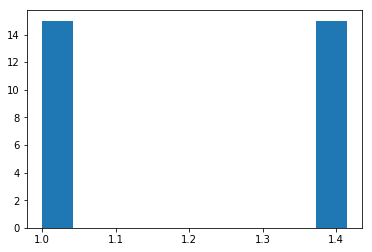

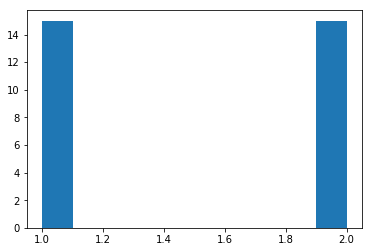

qid 0 [1.0, 1.0]
qid 1 [1.0, 1.0]
qid 2 [1.0, 1.0]
qid 3 [1.0, 1.0]
qid 4 [1.0, 1.0]
qid 5 [1.0, 0]
qid 6 [1.0, 1.0]
qid 7 [1.0, 0]
qid 8 [0, 1.0]
qid 9 [1.0, 1.0]
qid 10 [1.0, 1.0]
qid 11 [0, 1.0]
qid 12 [1.0, 1.0]
qid 13 [0, 1.0]
qid 14 [0, 1.0]
qid 15 [1.0, 0]
qid 16 [1.0, 0]
qid 17 [0, 1.0]
qid 18 [1.0, 0]
qid 19 [1.0, 0]
qid 20 [1.0, 1.0]
qid 21 [1.0, 1.0]
qid 22 [1.0, 0]
qid 23 [1.0, 1.0]
qid 24 [1.0, 1.0]
qid 25 [0, 1.0]
qid 26 [0, 1.0]
qid 27 [0, 1.0]
qid 28 [1.0, 1.0]
qid 29 [1.0, 1.0]
RANU WONO , skill=0.00 across 0 comps
JYNA MIJY , skill=1.00 across 1 comps
RATU MYPHE , skill=0.00 across 0 comps
PHYM POT , skill=0.00 across 0 comps
BASIP RYPHY , skill=0.00 across 0 comps
CHAGIM FEWU , skill=1.41 across 2 comps
RETHU PHOSUS , skill=0.00 across 0 comps
TOC SUSI , skill=1.41 across 2 comps
HIBAR JYTHOCH , skill=1.41 across 2 comps
PYKU PHYN , skill=1.41 across 2 comps
PYP PHYK , skill=0.00 across 0 comps
LANU CHIPH , skill=0.00 across 0 comps
THAHI KEJ , skill=0.00 across 0 co

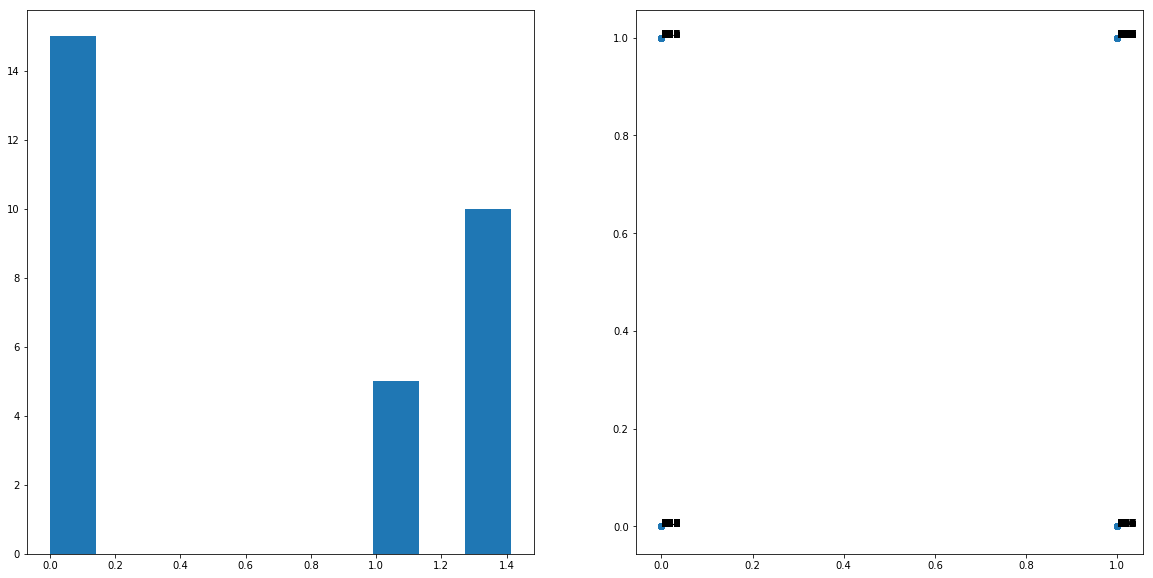

----0

>>Passed 12820/30000
----0

>>Passed 12820/30000


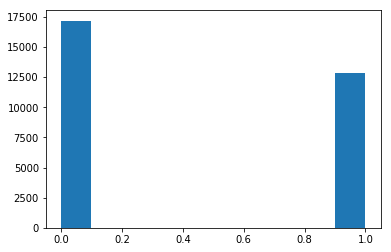

<__main__.BigTable object at 0x7fc72c62bc50> <__main__.BigTable object at 0x7fc6bf0cf048> Tensor("psi_select_87:0", shape=(?, 1), dtype=int32) Tensor("q_select_87:0", shape=(?, 1), dtype=int32)
psi_sel shape (?, 1)
kk (30, 2)
selector shape (?, 1)
flat selector shape (?,)
call kk (30, 2)
'rows' shape, (?, 2)
kk (1000, 2)
selector shape (?, 1)
flat selector shape (?,)
call kk (1000, 2)
'rows' shape, (?, 2)
Pr (?, 1)
[ 0.05593891  0.05320674]
[ 0.04343182  0.02442678]
[ 0.05693413  0.06073625]
[ 0.00368786  0.00319469]
[ 0.06940673  0.09748335]
[ 0.02512254  0.036556  ]
[ 0.08257222  0.07716589]
[ 0.09012688  0.0204201 ]
[ 0.04058155  0.03634291]
[ 0.03928296  0.06279695]
[ 0.09076005  0.0324154 ]
[ 0.01937003  0.02150929]
[ 0.04066833  0.02394547]
[ 0.00815663  0.05227176]
[ 0.0363616   0.09891339]
[ 0.07346059  0.06187864]
[ 0.03429144  0.04461232]
[ 0.04718991  0.0187319 ]
[ 0.03891348  0.09089652]
[ 0.06752682  0.02974666]
[ 0.02497255  0.05132138]
[ 0.07824425  0.02913266]
[ 0.08698

[ 0.08025814  0.06074741]
[ 0.09469628  0.07773463]
[ 0.05834277  0.05653074]
[ 0.01254636  0.02574707]
[ 0.0177482  0.0108216]
[ 0.04107301  0.05445563]
[ 0.07629136  0.00124994]
[ 0.04424896  0.05631616]
[ 0.0959456   0.09673437]
[ 0.07601201  0.04590032]
[ 0.07942571  0.04825721]
[ 0.90474355  0.90409636]
[ 0.92053127  0.96276426]
[ 0.96224886  0.99242693]
[ 0.9667576   0.90679455]
[ 0.982912   0.9692868]
[ 0.97611266  0.97993457]
[ 0.93818724  0.97178215]
[ 0.95493096  0.94524884]
[ 0.9025721   0.94813412]
[ 0.90602082  0.93831098]
[ 0.93070537  0.97927463]
[ 0.9440316   0.96293616]
[ 0.98732907  0.92002863]
[ 0.9251771   0.97283405]
[ 0.90958971  0.94305211]
[ 0.90536171  0.95310581]
[ 0.91670465  0.95765942]
[ 0.98127842  0.99071294]
[ 0.96732312  0.92045999]
[ 0.93019527  0.97552747]
[ 0.97370911  0.9205184 ]
[ 0.92601609  0.94231814]
[ 0.99822772  0.91143179]
[ 0.96395487  0.90122426]
[ 0.91921395  0.92809129]
[ 0.90200675  0.90021127]
[ 0.96530837  0.96910632]
[ 0.91466314  0.

i = 480
th 0.0313471031785
b 0.11039923355
0.283491533021
0.0708731683642 0.0167177961215 0.972833333333
loss = 0.0708731683642
patience now 97
i = 490
th 0.0313470755219
b 0.110397781183
0.283489608904
0.0708724283526 0.0167179359665 0.972833333333
loss = 0.0708724283526
patience now 96
i = 500
th 0.0313470425308
b 0.110404176762
0.283498716315
0.0708756096462 0.0167173205661 0.972833333333
loss = 0.0708756096462
patience now 95
i = 510
th 0.0313471559286
b 0.110397901386
0.28348990796
0.0708725286573 0.0167179245101 0.972833333333
loss = 0.0708725286573
patience now 94
i = 520
th 0.0313469787836
b 0.110402356833
0.283494919519
0.0708746678084 0.0167174954558 0.972833333333
loss = 0.0708746678084
patience now 93
i = 530
th 0.0313472308815
b 0.110397737473
0.283489873449
0.0708724841774 0.0167179405059 0.972833333333
loss = 0.0708724841774
patience now 92
i = 540
th 0.0313469051421
b 0.110406739761
0.283499809106
0.0708768224518 0.0167170738309 0.972833333333
loss = 0.0708768224518
pat

i = 1050
th 0.03134790501
b 0.110401733965
0.283496891061
0.0708748194873 0.0167175554567 0.972833333333
loss = 0.0708748194873
patience now 82
i = 1060
th 0.0313465848267
b 0.110404105236
0.283496732076
0.0708753450314 0.0167173287857 0.972833333333
loss = 0.0708753450314
patience now 81
i = 1070
th 0.0313478750587
b 0.110401063412
0.283495219767
0.0708744692355 0.0167176199665 0.972833333333
loss = 0.0708744692355
patience now 80
i = 1080
th 0.0313467492163
b 0.110397651047
0.283488799493
0.0708722001314 0.0167179487074 0.972833333333
loss = 0.0708722001314
patience reset to 100
i = 1090
th 0.03134779495
b 0.110403447598
0.283497789959
0.0708756212741 0.0167173903211 0.972833333333
loss = 0.0708756212741
patience now 99
i = 1100
th 0.0313469305038
b 0.110397865623
0.283489465336
0.0708723980635 0.0167179279994 0.972833333333
loss = 0.0708723980635
patience now 98
i = 1110
th 0.031347676605
b 0.110399680585
0.283493252079
0.0708736785948 0.0167177530963 0.972833333333
loss = 0.0708736

i = 1620
th 0.0313478444219
b 0.110399341832
0.283493078768
0.0708735931267 0.0167177858109 0.972833333333
loss = 0.0708735931267
patience now 88
i = 1630
th 0.031346652627
b 0.110411793242
0.28350852555
0.0708792229344 0.0167165907004 0.972833333333
loss = 0.0708792229344
patience now 87
i = 1640
th 0.0313481228054
b 0.110400365045
0.283494790753
0.070874243925 0.0167176869579 0.972833333333
loss = 0.070874243925
patience now 86
i = 1650
th 0.0313463037312
b 0.110410419355
0.283503688176
0.070878361543 0.0167167221075 0.972833333333
loss = 0.070878361543
patience now 85
i = 1660
th 0.0313483756185
b 0.110398590813
0.283493255198
0.0708734832158 0.0167178581328 0.972833333333
loss = 0.0708734832158
patience now 84
i = 1670
th 0.0313460592628
b 0.110418124249
0.283511893411
0.0708820917557 0.0167159828657 0.972833333333
loss = 0.0708820917557
patience now 83
i = 1680
th 0.0313485536277
b 0.110402070731
0.283498631279
0.0708753121793 0.0167175228972 0.972833333333
loss = 0.0708753121793


i = 2190
th 0.0313465388715
b 0.110397999734
0.283488796631
0.0708722693026 0.0167179151115 0.972833333333
loss = 0.0708722693026
patience now 73
i = 2200
th 0.0313485738933
b 0.110405715555
0.283502490083
0.0708771447241 0.0167171729343 0.972833333333
loss = 0.0708771447241
patience now 72
i = 2210
th 0.0313467609286
b 0.110397770256
0.283488975505
0.0708722655922 0.0167179372818 0.972833333333
loss = 0.0708722655922
patience now 71
i = 2220
th 0.0313481896818
b 0.110410210739
0.283506722569
0.0708792002102 0.0167167404726 0.972833333333
loss = 0.0708792002102
patience now 70
i = 2230
th 0.031347022295
b 0.110399606079
0.283492091517
0.0708733141869 0.0167177601222 0.972833333333
loss = 0.0708733141869
patience now 69
i = 2240
th 0.0313477587104
b 0.110401943574
0.283496312916
0.0708748511424 0.0167175357448 0.972833333333
loss = 0.0708748511424
patience now 68
i = 2250
th 0.0313473408818
b 0.110399499784
0.283492286185
0.0708734203329 0.0167177704255 0.972833333333
loss = 0.070873420

i = 2760
th 0.0313461670578
b 0.110397651047
0.283487635175
0.0708719090521 0.0167179486826 0.972833333333
loss = 0.0708719090521
patience now 16
i = 2770
th 0.0313490429223
b 0.110404549291
0.283501656254
0.0708767961065 0.0167172843232 0.972833333333
loss = 0.0708767961065
patience now 15
i = 2780
th 0.0313462420404
b 0.110397890459
0.283488120914
0.0708720662495 0.0167179258025 0.972833333333
loss = 0.0708720662495
patience now 14
i = 2790
th 0.0313492706716
b 0.110399985562
0.283496830583
0.0708746281167 0.0167177239212 0.972833333333
loss = 0.0708746281167
patience now 13
i = 2800
th 0.0313463355303
b 0.110397885491
0.283488266011
0.0708721105109 0.016717926032 0.972833333333
loss = 0.0708721105109
patience now 12
i = 2810
th 0.0313492361605
b 0.110406411936
0.28350606068
0.0708778240482 0.0167171058692 0.972833333333
loss = 0.0708778240482
patience now 11
i = 2820
th 0.031346455127
b 0.110398009668
0.283488641381
0.0708722323974 0.0167179138251 0.972833333333
loss = 0.07087223239

/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in double_scalars
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/ipykernel_launcher.py:119: RuntimeWarning: invalid value encountered in less
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in greater_equal
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in less
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in greater_equal
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in less
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/ipykernel_launcher.py:122: RuntimeWarning: invalid value encountered in greater_equal


embed acc: 1.9565333333333332
24336 0
1304 34360
pearson's corr/n: (0.91373936058564997, 0.0)


In [434]:
stages=[100]
n_traits = 2
min_active_traits = 1
max_active_traits = 2
opt = Adam(lr=.01)

histoires = []

try:
    volume_to_r
    maes
except NameError:
# if True:
    volume_to_r = []
    maes = []

for _ in range(1):
    for ix,volume in enumerate(stages):

        n_qs = 30
        n_students = 1000
    #     if not qs:
        corz=[]
        maez=[]
        for rvn in range(1):
            qs= create_qs(n_qs, 0,1, n_traits, min_active_traits, max_active_traits)
            ss= create_students(n_students, 0,1, n_traits)
            attempts, attempts_by_q, attempts_by_psi, attempts_n_map = generate_attempts(qs,ss)
            v, _, _, _ = generate_attempts(qs,ss)

            peas = [ tup[3] for tup in attempts ]
            plt.hist(peas)
            plt.show()
        #     break

            q_table = BigTable((n_qs, n_traits),min_w=0, max_w=1)
            s_table = BigTable((n_students, n_traits), min_w=0, max_w=1)

            q_model = None
            s_model = None
            qs_model = generate_qs_model(q_table, s_table, None, None, opt)

            init_weights(qs, ss, attempts_by_psi, attempts_by_q, q_table, s_table, 0, 1, 0, 1)
            
            h, min_loss = calibrate(qs,ss, qs_model, attempts, v, attempts_by_psi, attempts_by_q, s_table, q_table, None, None, n_iter=100000, record_param_fit=True)
            histoires.append(h)

            sws = s_table.get_weights()[0]
            pred_wgtz = q_table.get_weights()[0]

            df = results_sheet(qs,ss, sws, pred_wgtz)

            from scipy.stats import spearmanr, pearsonr
            r = pearsonr(df["p0"], df["p_mined"])
            corz.append(r)

            print("pearson's corr/n:", r)
            (smae, qmae) = calc_avg_MAE(qs,ss,sws,pred_wgtz)
            maez.append((smae,qmae))

        volume_to_r.append((volume, mean([c[0] for c in corz]), [c[1] for c in corz]))
        mean_smae = mean([e[0] for e in maez ])
        mean_qmae = mean([e[1] for e in maez ])
        maes.append((volume, mean_smae, mean_qmae))

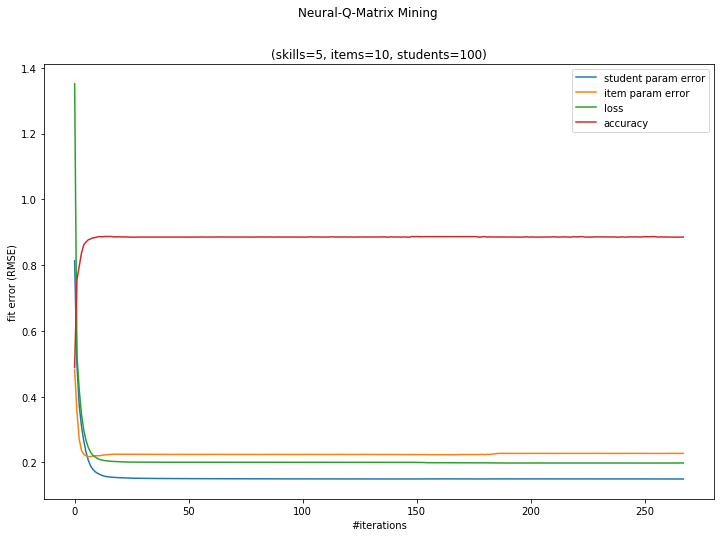

In [402]:
xs = list(range(len(h)))
therr = [tup[0] for tup in h]
berr = [tup[1] for tup in h]
accs = [tup[4] for tup in h]
lossz = [tup[2] for tup in h]

plt.plot(xs, therr, label="student param error")
plt.plot(xs, berr, label="item param error"),

plt.plot(xs, lossz, label="loss")
plt.plot(xs, accs, label="accuracy"),

# plt.plot(xs, accs, "m")
# plt.plot(xs, numpy.multiply(1,s_outer_accs), "g")
# plt.plot(xs, numpy.multiply(1,q_outer_accs), "k")

# plt.plot(xs, numpy.multiply(1,mses), "m--")
# plt.plot(xs, numpy.multiply(1,s_outer_mses), "g--")
# plt.plot(xs, numpy.multiply(1,q_outer_mses), "k--")
fig = plt.gcf()
fig.set_size_inches(12, 8)
plt.xlabel("#iterations")
plt.ylabel("fit error (RMSE)")
plt.suptitle("Neural-Q-Matrix Mining")
plt.title("(skills=5, items=10, students=100)")
plt.legend()
plt.show()

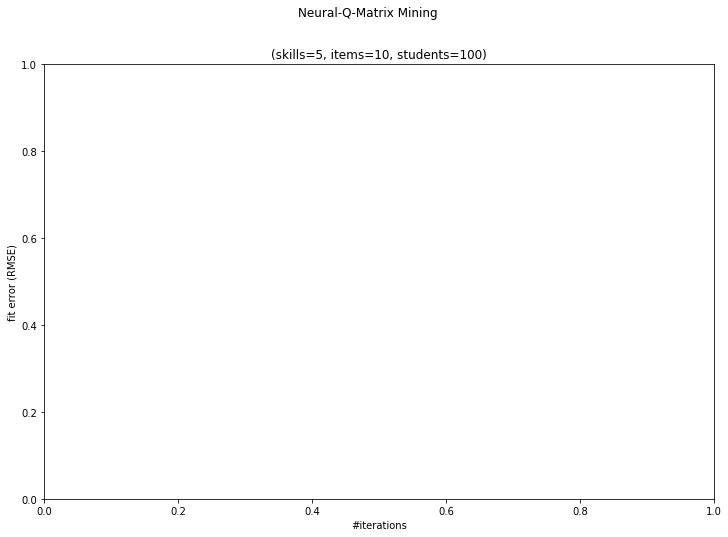

In [88]:
for th_rmses, b_rmses in serieses:
    xs =range(len(th_rmses))
    plt.plot(xs, numpy.multiply(1,th_rmses), label="w=5, students"),
    plt.plot(xs, numpy.multiply(1,b_rmses), label="w=5, qns")

# plt.plot(xs, accs, "m")
# plt.plot(xs, numpy.multiply(1,s_outer_accs), "g")
# plt.plot(xs, numpy.multiply(1,q_outer_accs), "k")

# plt.plot(xs, numpy.multiply(1,mses), "m--")
# plt.plot(xs, numpy.multiply(1,s_outer_mses), "g--")
# plt.plot(xs, numpy.multiply(1,q_outer_mses), "k--")
fig = plt.gcf()
fig.set_size_inches(12, 8)
plt.xlabel("#iterations")
plt.ylabel("fit error (RMSE)")
plt.suptitle("Neural-Q-Matrix Mining")
plt.title("(skills=5, items=10, students=100)")
plt.legend()
plt.show()

In [399]:
n_traits = 5
nn_dimensions = [1,3,5,7,9]
serieses = []
min_errs = []
n_qs = 10
n_students = 1000
for ix,nnw in enumerate(nn_dimensions):
    qs = create_qs(n_qs, n_traits, nnw, optimiser=qopt)
    ss = create_students(n_students, n_traits, nnw, optimiser=qopt)
    attempts_by_psi, attempts_by_q = generate_attempts(qs,ss)
    print(qs[0].pred_betas.get_weights()[0][0])
    print(ss[0].pred_theta.get_weights()[0][0])
    resultz = calibrate(qs,ss,attempts_by_q, attempts_by_psi, n_iter=70)
    serieses.append( resultz )
#     if ix < len(serieses): #append to old series
#         (_mses,_accs) = serieses[ix]
#         _mses += mses
#         _accs += accs
#         serieuses[ix] = (_mses,_accs)
#     else: #create new series
#         serieses.append((mses,accs))
    
from pygame import mixer
mixer.init()
mixer.music.load('calibration_complete.mp3')
mixer.music.play()

TypeError: create_qs() got an unexpected keyword argument 'optimiser'

In [ ]:
# import pickle
# pickle.dump( serieses, open( "serieses.p", "wb" ) )

xmax=10
xs = range(len(serieses[0][0]))[0:xmax]
print(len(serieses))
for s in serieses:
    print(len(s))
# plt.plot(xs, numpy.multiply(1,theta_rmses), 'b--')
# plt.plot(xs, numpy.multiply(1,beta_rmses), 'b')
fig, axes = plt.subplots(nrows=3, ncols=2)
print(axes.shape)
for (mses,accs, th_mses,th_accs, b_mses,b_accs),c,d in zip(serieses,["r--","y--","k-","c--","b--"],nn_dimensions):
    axes[0,0].plot(xs, numpy.multiply(1,mses[0:xmax]), c, label="nnw={}".format(d))
    axes[0,1].plot(xs, numpy.multiply(1,accs[0:xmax]), c, label="nnw={}".format(d))
    axes[1,0].plot(xs, numpy.multiply(1,th_mses[0:xmax]), c, label="nnw={}".format(d))
    axes[1,1].plot(xs, numpy.multiply(1,th_accs[0:xmax]), c, label="nnw={}".format(d))
    axes[2,0].plot(xs, numpy.multiply(1,b_mses[0:xmax]), c, label="nnw={}".format(d))
    axes[2,1].plot(xs, numpy.multiply(1,b_accs[0:xmax]), c, label="nnw={}".format(d))

# plt.plot(xs, accs, "m")
# plt.plot(xs, numpy.multiply(1,s_outer_accs), "g")7
# plt.plot(xs, numpy.multiply(1,q_outer_accs), "k")

# plt.plot(xs, numpy.multiply(1,mses), "m--")
# plt.plot(xs, numpy.multiply(1,s_outer_mses), "g--")
# plt.plot(xs, numpy.multiply(1,q_outer_mses), "k--")
for ix in range(axes.shape[0]):
    subcats = ["Combined","Student","Question"]
    for iy in range(axes.shape[1]):
        axes[ix,iy].set_xlabel("#iterations")
        axes[ix,iy].legend()
        if iy==0:
            axes[ix,iy].set_title("{} fit error".format(subcats[ix]))
            axes[ix,iy].set_ylabel("fit error (RMSE)")
        else:
            axes[ix,iy].set_title("{} fit accuracy".format(subcats[ix]))
            axes[ix,iy].set_ylabel("prediction accuracy")

fig.suptitle("Neural-MLTM Parameter Fitting (k={}, q={}, s={})".format(n_traits, n_qs, n_students))
fig.set_size_inches(18, 18)

fig.show()

In [403]:
s_wgtz = array([ s.thetas for s in ss ])
shat_wgtz = s_table.get_weights()[0]
shat, min_total_err, mean_ll, cos_dis = calc_arr_arr_err(s_wgtz, shat_wgtz, max_iter=10)

# for real,out in zip(s_wgtz, shat):
#     print(real," -- ",out)
# print(pred_wgts)
# print("out", chosen)
print("best cos distance:", cos_dis)
print("elementwise mae:", min_total_err)
print("mean lead/lag", mean_ll)

real_wgtz = array([ q.betas for q in qs ])
pred_wgtz = q_table.get_weights()[0]
chosen, min_total_err, mean_ll, cos_dis = calc_arr_arr_err(real_wgtz, pred_wgtz, max_iter=10)

# for real,out in zip(real_wgtz, chosen):
#     print(real," -- ",out)
# print(pred_wgts)
# print("out", chosen)
print("best cos distance:", cos_dis)
print("elementwise mae:", min_total_err)
print("mean lead/lag", mean_ll)

best cos distance: 0.101827841616
elementwise mae: 0.193027223034
mean lead/lag -0.148463134964
best cos distance: 0.306877913091
elementwise mae: 0.284550065796
mean lead/lag -0.221816135558


In [404]:
itemz = array([ q.betas for q in qs ])
for i,c in zip(itemz,chosen):
    print(i)
    print(c)
    print(i==c)

[ 0.  0.  1.  0.  1.  1.  1.  1.  0.  0.]
[ 0.          0.          0.          0.          1.          0.77502531
  0.          0.          1.          0.        ]
[ True  True False  True  True False False False False  True]
[ 1.  1.  1.  1.  0.  0.  0.  0.  0.  0.]
[ 0.  1.  1.  0.  0.  0.  0.  0.  0.  0.]
[False  True  True False  True  True  True  True  True  True]
[ 1.  0.  1.  0.  1.  1.  1.  1.  1.  1.]
[ 1.          0.          0.          0.          1.          1.          0.
  0.          1.          0.01256936]
[ True  True False  True  True  True False False  True False]
[ 0.  1.  0.  1.  0.  1.  1.  0.  0.  1.]
[ 0.          1.          0.          0.          0.          0.
  0.49060187  0.          0.          1.        ]
[ True  True  True False  True False False  True  True  True]
[ 0.  0.  0.  1.  0.  0.  0.  0.  1.  0.]
[ 0.          0.          0.          0.          0.          0.          0.
  0.31923136  0.          0.4818323 ]
[ True  True  True False  True  

(30, 10) (30, 10)


/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


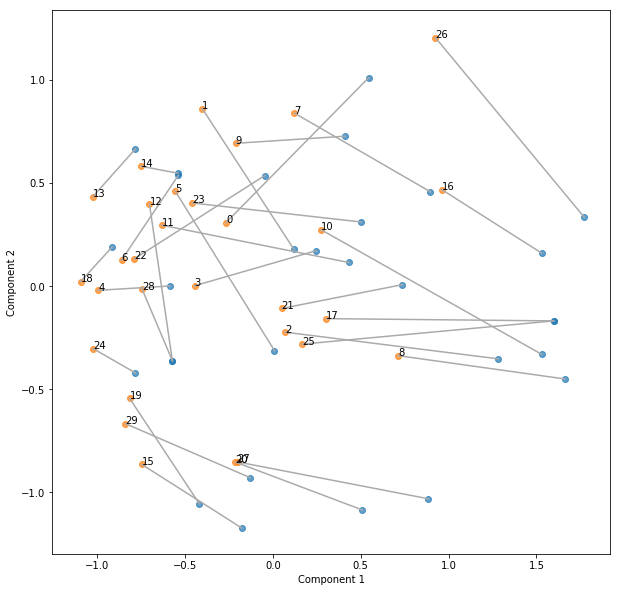

In [405]:
## fig = plt.gcf()
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
# pca = TSNE(n_components=2)
# pca2 = TSNE(n_components=2)

itemz = array([ q.betas for q in qs ])
# ixes = itemz < baseline
# itemz[ixes] = (baseline-1)
# itemz = itemz - (baseline-1)

itemz_pred = chosen
n = len(chosen)
rot = array([[-1,0],[0,-1]])

print(itemz.shape, itemz_pred.shape)


# itemz_pred = pca.transform(itemz_pred)

itemz_2 = numpy.concatenate([itemz, itemz_pred], axis=0)
itemz_2 = pca.fit_transform(itemz_2)

# for nx in range(n):
#     itemz_2[n+nx] = rot @ itemz_2[n+nx]


# itemz_2 = MinMaxScaler().fit_transform(itemz_2)

# ixes = itemz_pred < baseline
# itemz_pred[ixes] = (baseline-1)
# itemz_pred = itemz_pred - (baseline-1)
# itemz_pred = MinMaxScaler().fit_transform(itemz_pred)
# print(itemz_2)

# fig,axs = plt.subplots(1,2)
fig = plt.gcf()
fig.set_size_inches(10, 10)

fig.gca().scatter(itemz_2[0:n,0], itemz_2[0:n,1], alpha=0.7)
fig.gca().scatter(itemz_2[n:,0], itemz_2[n:,1], alpha=0.7)
j=0
for j in range(n):
    x,xh,y,yh = itemz_2[j,0], itemz_2[j+n,0], itemz_2[j,1], itemz_2[j+n,1]
    fig.gca().plot([x,xh],[y,yh],color="#aaaaaa")
    fig.gca().annotate(j, (itemz_2[j+n,0], itemz_2[j+n,1]))

# fig.gca().scatter(itemz_pred[:,0], itemz_pred[:,1], alpha=0.5)

# for i, txt in enumerate(itemz_2):
#     fig.gca().annotate(i, (itemz_2[i,0], itemz_2[i,1]))

# fig.gca().axvline(x=baseline, linestyle="--")
# fig.gca().axhline(y=baseline, linestyle="--")

plt.xlabel("Component 1")
plt.ylabel("Component 2")
fig.show()